# Step 1: Install Dependencies and Import Libraries

In [3]:
# Install necessary libraries if they are not already installed
!pip install pandas numpy matplotlib scikit-learn tensorflow

# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout


# Step 2: Load and Inspect the Data

In [5]:
# Load the dataset
file_path = '/kaggle/input/weather-dataset/weatherHistory.csv'  # Update path accordingly
weather_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
weather_data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# Step 3: Handle Missing Values

In [6]:
# Check for missing values in the dataset
print(weather_data.isnull().sum())

# Fill missing values with forward fill or backward fill
weather_data.fillna(method='ffill', inplace=True)

# Alternatively, you can drop rows with missing values
# weather_data.dropna(inplace=True)

# Verify if the missing values are handled
print(weather_data.isnull().sum())

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64
Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64


<ipython-input-6-b4dd8d495d57>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_data.fillna(method='ffill', inplace=True)


# Step 4: Convert Date/Timestamp to datetime

In [7]:
# Convert 'Formatted Date' to datetime format
weather_data['Formatted Date'] = pd.to_datetime(weather_data['Formatted Date'])

# Verify the column type
print(weather_data.dtypes)

Formatted Date               object
Summary                      object
Precip Type                  object
Temperature (C)             float64
Apparent Temperature (C)    float64
Humidity                    float64
Wind Speed (km/h)           float64
Wind Bearing (degrees)      float64
Visibility (km)             float64
Loud Cover                  float64
Pressure (millibars)        float64
Daily Summary                object
dtype: object


<ipython-input-7-b65ab8ce4bad>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  weather_data['Formatted Date'] = pd.to_datetime(weather_data['Formatted Date'])


# Step 5: Select Relevant Features for Forecasting

In [8]:
# Select relevant columns
selected_columns = ['Formatted Date', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']

# Filter the dataset for selected columns
weather_data_filtered = weather_data[selected_columns]

# Display the filtered data
print(weather_data_filtered.head())


              Formatted Date  Temperature (C)  Humidity  Wind Speed (km/h)  \
0  2006-04-01 00:00:00+02:00         9.472222      0.89            14.1197   
1  2006-04-01 01:00:00+02:00         9.355556      0.86            14.2646   
2  2006-04-01 02:00:00+02:00         9.377778      0.89             3.9284   
3  2006-04-01 03:00:00+02:00         8.288889      0.83            14.1036   
4  2006-04-01 04:00:00+02:00         8.755556      0.83            11.0446   

   Pressure (millibars)  
0               1015.13  
1               1015.63  
2               1015.94  
3               1016.41  
4               1016.51  


# Step 6: Normalize the Data

In [9]:
# Normalize the data (values will be scaled to the range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weather_data_filtered[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']])

# Check the scaled data
print(scaled_data[:5])

[[0.50697507 0.89       0.2211296  0.97013513]
 [0.50508505 0.86       0.22339889 0.97061297]
 [0.50544505 0.89       0.06152295 0.97090923]
 [0.48780488 0.83       0.22087746 0.9713584 ]
 [0.49536495 0.83       0.17297025 0.97145397]]


# Step 7: Create Sequences for Time-Series Forecasting

In [10]:
# Create sequences (X) and labels (y)
sequence_length = 60  # Using the past 60 hours to predict the next hour

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, :])  # Past 60 time steps data
    y.append(scaled_data[i, 0])  # Next hour's temperature (forecasting temperature)

X, y = np.array(X), np.array(y)

# Reshape X to be compatible with LSTM/GRU input (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Verify the shape of the data
print(X.shape, y.shape)

(96393, 60, 4) (96393,)


# Step 8: Split Data into Training and Test Sets

In [11]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (77114, 60, 4)
X_test shape: (19279, 60, 4)


# Step 9: Build the RNN Model (LSTM/GRU)

In [12]:
# Build the RNN Model (LSTM)
model = Sequential()

# Adding LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Adding dropout for regularization

# Adding another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Predicting temperature for the next hour

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summarize the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

# Step 10: Train the Model

Epoch 1/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 124s 50ms/step - loss: 0.0067 - val_loss: 6.4036e-04
Epoch 2/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 120s 50ms/step - loss: 0.0014 - val_loss: 4.0356e-04
Epoch 3/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - loss: 8.8981e-04 - val_loss: 4.0622e-04
Epoch 4/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - loss: 7.7803e-04 - val_loss: 3.5118e-04
Epoch 5/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 119s 49ms/step - loss: 7.4659e-04 - val_loss: 3.5095e-04
Epoch 6/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - loss: 7.3762e-04 - val_loss: 3.5412e-04
Epoch 7/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 118s 49ms/step - loss: 7.0712e-04 - val_loss: 3.8003e-04
Epoch 8/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 119s 50ms/step - loss: 6.7666e-04 - val_loss: 3.4353e-04
Epoch 9/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 119s 50ms/step - loss: 6.5839e-04 - val_loss: 3.3521e-04
Epoch 10/10
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 119s 49ms/step - loss: 6.6023e-04 - val_loss: 3.3303e-04


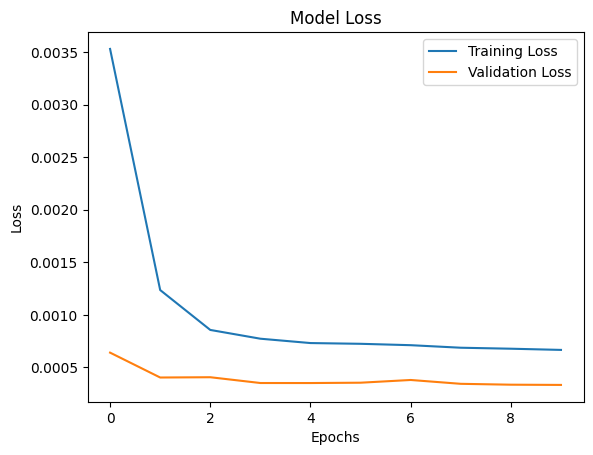

In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()